<h1 style="font-size:300%">ANIMAL SOUND CLASSIFIER</h1>


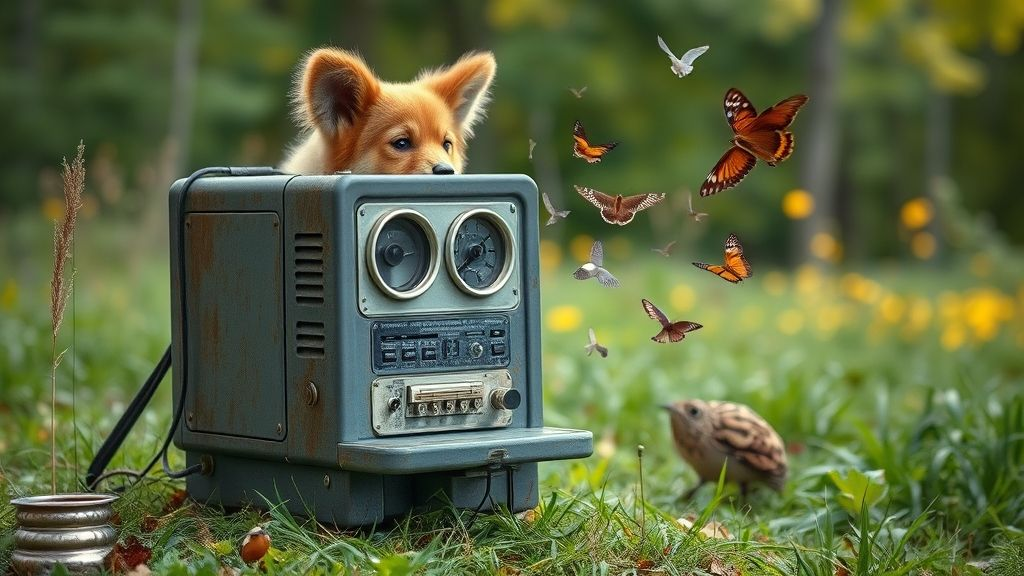

In [1]:
import csv, pandas, platform, os, seaborn
import torch as T 
import pytorch_lightning as L
import torch.utils.data as D
import torchmetrics as M

data_path = "data"

T.manual_seed(0)

print("Versions: python", platform.python_version(), "| torch", T.__version__, "| pytorch_lightning", L.__version__)

Versions: python 3.13.2 | torch 2.6.0+cpu | pytorch_lightning 2.5.0.post0


In [7]:
class AudioDataset(D.Dataset):
    def __init__(self, path):
        self.path = path
        self.files = []
        self.labels = []
        self.classes = []

        for folder in os.listdir(path):
            folder_path = os.path.join(path, folder)
            if os.path.isdir(folder_path):
                if folder not in self.classes:
                    self.classes.append(folder)
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        self.files.append(os.path.join(folder_path, file))
                        self.labels.append(self.classes.index(folder))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        label = self.labels[idx]
        audio, sr = librosa.load(file, sr=None)

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.n_mfccs)
        mfccs_mean = T.mean(T.tensor(mfccs, dtype=T.float32), dim=1)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = T.mean(T.tensor(chroma, dtype=T.float32), dim=1)

        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        spectral_contrast_mean = T.mean(T.tensor(spectral_contrast, dtype=T.float32), dim=1)

        features = T.cat((mfccs_mean, chroma_mean, spectral_contrast_mean))
        return features, label

dataset = AudioDataset(data_path)


In [8]:
train, val, test = D.random_split(dataset, [.6, .3, .1])
datamodule = L.LightningDataModule.from_datasets(train, val, test, batch_size=32, num_workers=0)
print("Created a DataModule with:", len(datamodule.train_dataloader().dataset), "training items,", len(datamodule.val_dataloader().dataset), "validation items and", len(datamodule.test_dataloader().dataset), "test items.")

Created a DataModule with: 124 training items, 61 validation items and 20 test items.


In [ ]:
from pytorch_lightning import LightningModule
from torch import nn
from torchmetrics import Accuracy, Precision, Recall

class AudioClassifier(L.LightningModule):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes, average="none")
        self.precision = Precision(task="multiclass", num_classes=num_classes, average="none")
        self.recall = Recall(task="multiclass", num_classes=num_classes, average="none")

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])

num_features = dataset.num_features()
num_classes = len(dataset.classes)
model = AudioClassifier(num_features, num_classes)

# Train

Now, let's use the PyTorch Lightning Trainer to train the model with our Data Module. Rather than telling it beforehand how many epochs to train, we use an EarlyStopping callback that stops the training process when the model has reached convergence. Information is logged to a CSV logger that can be used after training to provide evaluation metrics.

In [ ]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

# Train the model

logger = CSVLogger(save_dir=".")
trainer = Trainer(max_epochs=5, logger=logger)
trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | Sequential          | 2.3 K  | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=20]


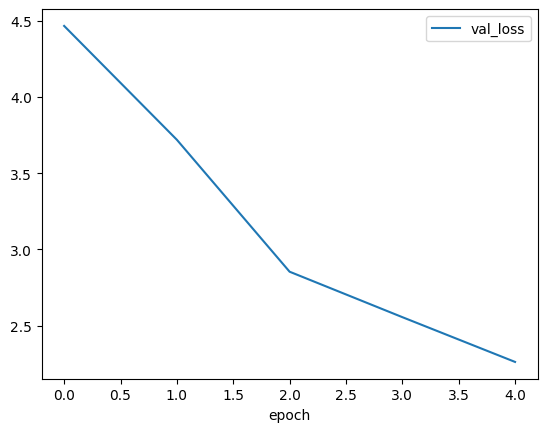

In [ ]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

# Test

Here we use the Trainer to run the model against the test data and collect the evaluation metrics.

In [ ]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(num_classes)]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(num_classes)]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(num_classes)]
df = pandas.DataFrame({"class": dataset.classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 11.40it/s] 


,accuracy,precision,recall
class,,,
chicken,0.200000,0.250000,0.200000
cow,0.571429,0.500000,0.571429
donkey,0.000000,0.000000,0.000000
frog,0.571429,0.333333,0.571429
sheep,0.454545,0.625000,0.454545


In [ ]:
test_dataloader = datamodule.test_dataloader()
files = [dataset.files[i] for i in test_dataloader.dataset.indices]
print(files)

preds = trainer.predict(model, dataloaders=test_dataloader)
predictions = torch.cat(preds)
predictions
#images = torch.cat([x for x, y in test_dataloader])
labels = torch.cat([y for x, y in test_dataloader])

for i, (file, truth, prediction) in enumerate(zip(files, labels, predictions)):
    probabilities = torch.softmax(prediction, dim=0)
    pred_class = torch.argmax(probabilities)
    print(i, file, dataset.classes[truth], dataset.classes[pred_class])

c:\Users\Bas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


['data\\donkey\\esek_16.wav', 'data\\chicken\\tavuk_8.wav', 'data\\chicken\\tavuk_9.wav', 'data\\cow\\inek_55.wav', 'data\\sheep\\koyun_20.wav', 'data\\sheep\\koyun_18.wav', 'data\\cow\\inek_72.wav', 'data\\sheep\\koyun_24.wav', 'data\\sheep\\koyun_16.wav', 'data\\sheep\\koyun_27.wav', 'data\\chicken\\tavuk_1.wav', 'data\\cow\\inek_66.wav', 'data\\cow\\inek_10.wav', 'data\\chicken\\tavuk_18.wav', 'data\\frog\\kurbaga_10.wav', 'data\\sheep\\koyun_31.wav', 'data\\cow\\inek_46.wav', 'data\\cow\\inek_13.wav', 'data\\donkey\\esek_10.wav', 'data\\sheep\\koyun_40.wav', 'data\\sheep\\koyun_19.wav', 'data\\sheep\\koyun_6.wav', 'data\\sheep\\koyun_21.wav', 'data\\frog\\kurbaga_30.wav', 'data\\donkey\\esek_21.wav', 'data\\frog\\kurbaga_7.wav', 'data\\cow\\inek_14.wav', 'data\\frog\\kurbaga_1.wav', 'data\\frog\\kurbaga_33.wav', 'data\\cow\\inek_68.wav', 'data\\cow\\inek_20.wav', 'data\\cow\\inek_3.wav', 'data\\frog\\kurbaga_34.wav', 'data\\cow\\inek_19.wav', 'data\\chicken\\tavuk_7.wav', 'data\\fr